# Arson Identifier

## Background

The goal of Arson Identifier is to identify whether or not Fuels are present in a cases of potential arson.

The Israeli DIFS has supplier us with spectra that was analyzed and tagged by a group of experts.

## Proposed Workflow

We are going to implement the following workflow

<br>
<br>
<img src ="img/Workflow.jpg" width = "1000">

In [1]:
# Import of the modules we'll be using

# Math modules
import numpy as np
import pandas as pd

from collections import Counter

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Standard sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Dl Modules
from tensorflow import keras

# Internally scripts written 
from helper_funcs import load_dbs
from helper_funcs import preprocess_data
from helper_funcs import logNorm
from helper_funcs import progress_bar
from helper_funcs import makeModelDyn
from helper_funcs import generate_spectrum

## Import Measurments

The spectra that was given, was given in multiple forms: an excel file and a csv file, each may contain one spectra or many. 

In [2]:
# The seperation for two batches is historical. The two batches are unified into one.
batch1 = {'BZ': ['many', 'Data/BZ - TRAIN'],
               'PD': ['many', 'Data/pd - Train'],
               'HR': ['one', 'Data/HOLER - TRAIN/HOLER-train.xlsx']
}

batch2 = {'BZ': ['one', 'Data/BZ - TEST/BZ.xlsx'],
               'PD': ['one', 'Data/pd - Test/pd.xlsx'],
               'HR': ['one', 'Data/HOLER - TEST/HOLER1.xlsx']
}

# An additional test case given by the DIFS
test = {'BZ': ['one', 'Data/BZ - TEST/BZ.xlsx'],
               'PD': ['one', 'Data/pd - Test/pd.xlsx'],
               'HR': ['one', 'Data/HOLER - TEST/HOLER1.xlsx']
}

For this purpose, the first step is to convert the data into a standard format of the form:
<br>
<br>
<table>
  <tr>
    <th>Time</th>
    <th>Count</th>
    <th>Class</th>
    <th>SampleID</th>
  </tr>
  <tr>
    <th>float - time interval (s)</th>
    <th>int - number of counts</th>
    <th>str - "BZ", "PD" or "HR"</th>
    <th>int - index of a sample</th>
  </tr>
</table>

In addition, the timestamps are standartized to be between 1(s) and 20(s) with incremets of 0.0065 (s)

In [3]:
try:
    training_db = pd.read_csv("Outputs/db.csv")
    print("Loaded training DB")
except:
    print("Training file not found, making a new one")
    dbs_batch1 = load_dbs(batch1)
    dbs_batch2 = load_dbs(batch2)
    dbs_batch2["SampleID"] += max(dbs_batch1["SampleID"])+1
    training_db = pd.concat([dbs_batch1, dbs_batch2])
    training_db.to_csv("Outputs/db.csv", index = False)
    print("Done making a training file")
try:
    test_db = pd.read_csv("Outputs/test.csv")
    print("Loaded test DB")
except:
    print("Testing file not found, making a new one")
    dbs_test = load_dbs(batch1)
    dbs_test.to_csv("Outputs/test.csv", index = False)
    print("Done making a test file")

Loaded training DB
Loaded test DB


Example of the "sorted db" that is composed of 181 samples:

In [4]:
training_db

,Time,Count,Class,SampleID
0,1.0000,0.0,BZ,0
1,1.0065,0.0,BZ,0
2,1.0130,0.0,BZ,0
3,1.0195,0.0,BZ,0
4,1.0260,0.0,BZ,0
...,...,...,...,...
529239,19.9735,21690.0,HR,180
529240,19.9800,22739.0,HR,180
529241,19.9865,44317.0,HR,180
529242,19.9930,22576.0,HR,180


In [5]:
# One sample will tange from 1 (m) to ~20 (m)
print("One sample looks like this:")
print(training_db[training_db["SampleID"]==0])

One sample looks like this:
         Time  Count Class  SampleID
0      1.0000    0.0    BZ         0
1      1.0065    0.0    BZ         0
2      1.0130    0.0    BZ         0
3      1.0195    0.0    BZ         0
4      1.0260    0.0    BZ         0
...       ...    ...   ...       ...
2919  19.9735    0.0    BZ         0
2920  19.9800    0.0    BZ         0
2921  19.9865    0.0    BZ         0
2922  19.9930    0.0    BZ         0
2923  19.9995    0.0    BZ         0

[2924 rows x 4 columns]


We know see that the size of spectra is always 2924 and that can be used to sort the samples to a matrix of A[i,j] where i is the index of the sample and j is the time index.

In addition, we wish to encode the textual classes to numbers. As follows:
<br>
<br>
<br>
<img src ="img/preprocess.jpg" width = "500">

## Continuous Spectra Discretization and data preperation

In [6]:
SIZE_OF_SPECTRA = 2924
# We will take the continuous spectra, convert it into discrete time units, and partition it to a feature matrix and a class vector. 
realSpectra, class_vec, label_encoder = preprocess_data(training_db, SIZE_OF_SPECTRA)
# realSpectra: Feature matrix. ith row contains an individual spectra
# class_vec: Classification vector. ith value contains the enumeration of a the class for the ith spectra
# label_encoder: The encoder class instance.

print("The shape of the processed training data is:",realSpectra.shape)
print("The size of the training class vector  is:",class_vec.shape)
print("Over all class distribution within the database is:")


def print_classes(class_vec, label_encoder):
    # A helper funtion to print the counts with names
    counts = Counter(class_vec)
    for key in counts.keys():
        print(label_encoder.classes_[key],":", str(counts[key]))
        
print_classes(class_vec, label_encoder)

The shape of the processed training data is: (181, 2924)
The size of the training class vector  is: (181,)
Over all class distribution within the database is:
BZ : 53
PD : 81
HR : 47


We can visualize each class seperatly

[Text(0.5, 0, 'Elapsed time (m)'), Text(0, 0.5, 'Counts')]

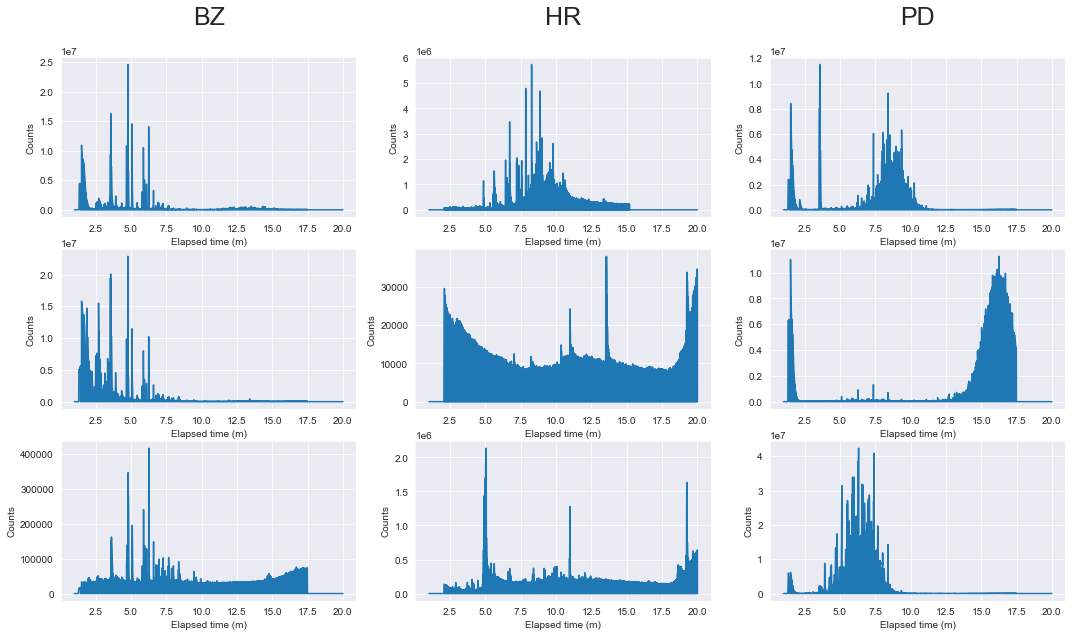

In [7]:
x = [i for i in np.arange(1,20,0.0065)]
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes[0, 0].set_title(label_encoder.inverse_transform(np.array([0]))[0] + '\n', size=25)
sns.lineplot(ax=axes[0, 0], x = x ,y = realSpectra[class_vec==0][1,:])
axes[0,0].set(xlabel='Elapsed time (m)', ylabel='Counts')
sns.lineplot(ax=axes[1, 0], x = x ,y = realSpectra[class_vec==0][2,:])
axes[1,0].set(xlabel='Elapsed time (m)', ylabel='Counts')
sns.lineplot(ax=axes[2, 0], x = x ,y = realSpectra[class_vec==0][3,:])
axes[2,0].set(xlabel='Elapsed time (m)', ylabel='Counts')

axes[0, 1].set_title(label_encoder.inverse_transform(np.array([1]))[0] + '\n', size=25)
sns.lineplot(ax=axes[0, 1], x = x ,y = realSpectra[class_vec==1][1,:])
axes[0,1].set(xlabel='Elapsed time (m)', ylabel='Counts')
sns.lineplot(ax=axes[1, 1], x = x ,y = realSpectra[class_vec==1][2,:])
axes[1,1].set(xlabel='Elapsed time (m)', ylabel='Counts')
sns.lineplot(ax=axes[2, 1], x = x ,y = realSpectra[class_vec==1][3,:])
axes[2,1].set(xlabel='Elapsed time (m)', ylabel='Counts')

axes[0, 2].set_title(label_encoder.inverse_transform(np.array([2]))[0] + '\n', size=25)
sns.lineplot(ax=axes[0, 2], x = x ,y = realSpectra[class_vec==2][1,:])
axes[0,2].set(xlabel='Elapsed time (m)', ylabel='Counts')
sns.lineplot(ax=axes[1, 2], x = x ,y = realSpectra[class_vec==2][2,:])
axes[1,2].set(xlabel='Elapsed time (m)', ylabel='Counts')
sns.lineplot(ax=axes[2, 2], x = x ,y = realSpectra[class_vec==2][3,:])
axes[2,2].set(xlabel='Elapsed time (m)', ylabel='Counts')

# Training | Validation split

Once the spectra has beed discretized, the database (realSpectra, and class_vec) is partitioned into a training and a validation set.<br> 

In [8]:
def train_val_partition(realSpectra, class_vec, test_size=0.33):   
    X_train, X_val, y_train, y_val = train_test_split(realSpectra, class_vec, test_size=0.33, stratify = class_vec)
    print("Training set is composed of:")
    print_classes(y_train, label_encoder)
    print("")
    print("Validation set is composed of:")
    print_classes(y_val, label_encoder)
    return X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = train_val_partition(realSpectra, class_vec)

Training set is composed of:
PD : 54
BZ : 36
HR : 31

Validation set is composed of:
BZ : 17
PD : 27
HR : 16


# Normalization

It is a good practice to normalize the discrete spectra before passing it to classification models. This is especially true for neural network, where values must be normalized to range between 0 and 1.
As the data spans over several orders of magnitude we calculate the log scale. Then, we normalized the values using the max and min values of the log values of the measured (real) spectra.
<br><br>
The normalization process works as follows:
- Calculate the log value of each element
- negative infinity values (log(0) were set to be 0
- log values were normalized as follows:
$$
normalized\, value = \frac{log\,value}{upper\, log\, bound - lower\, log\, bound} +lower\, log\, bound 
$$
<br>
- Values above max bound and below min mounds were set to be 0 and 1 respectivly

In [9]:
def normalize_spectra(X_train,X_val=None,realSpectraBounds=None,debug = False):
    np.seterr(divide='ignore')
    if realSpectraBounds is None:
        logSpec = np.log(X_train) # get log value of the entire matrix
        logSpec[np.isinf(logSpec)] = 0 # make log of -inf to 0
        realSpectraBounds = (np.min(logSpec), np.max(logSpec))
    X_train_norm = logNorm(X_train, realSpectraBounds) # Normalize training set
    if X_val is not None:
        X_val_norm = logNorm(X_val, realSpectraBounds) # Normalize test set
    else:
        X_val_norm = None
    if debug:
        # We can visuzalize the change
        gen_spec = 8
        fig, axes = plt.subplots(1,2)
        x = [i for i in np.arange(1,20,0.0065)]
        sns.lineplot(ax=axes[0], x = x ,y = X_train[gen_spec]).set(title='Before normalizing', xlabel='Elapsed time (s)', ylabel='Counts')
        sns.lineplot(ax=axes[1], x = x ,y = X_train_norm[gen_spec]).set(title='After normalizing', xlabel='Elapsed time (s)', ylabel='Counts')
        fig.tight_layout()
    return X_train_norm,X_val_norm,realSpectraBounds
X_train_norm,X_val_norm, realSpectraBounds = normalize_spectra(X_train,X_val)

## Applicability Domain and Spectrum Score

<p>The applicability domain for a classifying model on unknown spectra can be determined by the spectra it that have been used to build the model in the first place:</p>
<p>For each flammable class, we can define the mean and standard deviation of spectra signals at each timepoint.</p>
<p>For an unknown spectrum submitted to the model, we can assess if the signal is inside or outside the mean and standard deviation of the training set:</p>
<p>A "Spectrum Score" is defined as below in the figure:</p>
<br>
<img src ="img/spectrumScoreGraph.PNG" width = "1000">

<br>
For our purposes we can define this applicability domain for each class, look at each item in the test sets and try to explain model performance based on Spectrum Scores of test-set samples

# Synthesize new data

For classifiers that require more data than exsists (specifically, DL), there is a need to generate more data.

To do so, we will assume that any linear combination of spectra of the same type, will create a new spectra of that type.

The workflow is as follows:
- Randomly determine the amount of spectra that will be linearly combined - <B>N</B>
- Randomly sample that number of spectra from <I>realSpectra</I>
- Randomly draw N continuous numbers that act as weights - <B>W</B>
- Perform a dot multiplication

The amount of possible combinations can be calculated as:

$$
L = Total\, amount\, of \, spectra\, in\, a\, class \\
N = number\, of\, spectra \, to\, linearly\, combine \\
S = Sampled\, spectra \\
W = Weights\, vector \\
\\
combination = \sum_{k=1}^{L} {L \brack k}
$$
The new spectra is calculates as follows:
$$
s_i = The\, sampled\, i^{th}\, spectra \\
w_i = The \, i^{th}\, weight\\
new\, spectra = \sum_{k=1}^{N} s_i\cdot w_i\\
Or \\
new\, spectra = S\cdot W
$$
<br>
<br>
A sample of 40 specimens that contained both real and generated spectra was sent to a panel of two police experts.
The results located in /Outputs/police_test_15_08_21.csv
<br>
<br>

| |Expert 1| Expert 2|
|-----|-------|-----|
|Identification success ratio|60% | 75%|

<br>
On face value it seems that the synthesation process is valid as the results are close to 50% (max entropy). In addition, there is no agreement between the experts on some spectra, thus the samples may appear as authentic to some experts and inauthetic to others.

In [10]:
def syn_data(realSpectra, class_vec, batch_size=10**5, debug = False):
    synSpectra, syn_classes = generate_spectrum(realSpectra, class_vec, batch_size)
    synSpectra = np.squeeze(synSpectra)
    # For debugging purposes only
    if debug:
        fig, axes = plt.subplots(3, 2, figsize=(18, 10))
        gen_spec = 8
        sns.lineplot(ax=axes[0,0], data = X_train_norm[gen_spec]).set(title='Generated to be ' + label_encoder.classes_[classes[gen_spec]])
        sns.lineplot(ax=axes[0,1], data = synSpectra[gen_spec]).set(title='Generated to be ' + label_encoder.classes_[classes[gen_spec]])
        gen_spec = 5
        sns.lineplot(ax=axes[1,0], data = X_train_norm[gen_spec]).set(title='Generated to be ' + label_encoder.classes_[classes[gen_spec]])
        sns.lineplot(ax=axes[1,1], data = synSpectra[gen_spec]).set(title='Generated to be ' + label_encoder.classes_[classes[gen_spec]])
        gen_spec = 20
        sns.lineplot(ax=axes[2,0], data = X_train_norm[gen_spec]).set(title='Generated to be ' + label_encoder.classes_[classes[gen_spec]])
        sns.lineplot(ax=axes[2,1], data = synSpectra[gen_spec]).set(title='Generated to be ' + label_encoder.classes_[classes[gen_spec]])
    return synSpectra,syn_classes

#Synthesize new synthesized spectra
syn_spectra,syn_classes = syn_data(realSpectra, class_vec)
#Normalize synthesized spectra
syn_spectra_norm,_,synSpectraBounds = normalize_spectra(syn_spectra,realSpectraBounds=realSpectraBounds)

The Applicability Domain can be constructed from the real spectra or synthetically generated spectra

# Classification

Our goal is to create a proper classifier that will distinguish the samples classes.To this end, we will use several methods:
* RF
* kNN
* Representative Spectra (RS) for each class
* DL

Of which RF, kNN and DL have hyperparameters that needs to be tubed for optimal perforamces.
To this end, we will use random grid search and exhaustive grid search. <br>

This workflow has two classical ML classification algorithms with tunable hyperparameter. These classifiers will be applied on both the regular data and the regular + synthesized data. <br>
This means two sets of tunable hyperparameters for both classifiers.

We'll define representative spectra as the mean of all known spectra within the training set

While RF and kNN are self explanitory, the DL network that will be used, is a simple one:
The normalized training DB will now be an input to a 3 hidden, FC, layered NN
<br>

<img src ="img/nn.jpg" width = "300">

In [11]:
def repSpectraClass(train_set,class_vec,val_set, debug=False, label_encoder=None):
    # For the purpose of this work, there are three classes
    class0_rep = np.mean(train_set[class_vec==0],axis=0)
    class1_rep = np.mean(train_set[class_vec==1],axis=0)
    class2_rep = np.mean(train_set[class_vec==2],axis=0)
    
    y_pred = []
    for x in val_set:
        y_pred.append(np.argmin((np.sum(np.power(np.subtract(x,class0_rep),2)),  np.sum(np.power(np.subtract(x,class1_rep),2)), np.sum(np.power(np.subtract(x,class2_rep),2)))))
        
    x = [i for i in np.arange(1,20,0.0065)]

    if debug is True:
        fig, axes = plt.subplots(3, 3, figsize=(18, 10))

        axes[0, 0].set_title(label_encoder.inverse_transform(np.array([0]))[0] + '\n', size=25)
        axes[0, 1].set_title(label_encoder.inverse_transform(np.array([1]))[0] + '\n', size=25)
        axes[0,2].set_title(label_encoder.inverse_transform(np.array([2]))[0] + '\n', size=25)

        axes[0,2].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[0,0], x=x, y=class0_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[0,0], x=x, y=X_train_norm[y_train==0][0,:], alpha = 0.8)

        axes[0,1].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[1,0], x=x, y=class0_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[1,0], x=x, y=X_train_norm[y_train==0][10,:], alpha = 0.8)

        axes[0,2].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[2,0], x=x, y=class0_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[2,0], x=x, y=X_train_norm[y_train==0][21,:], alpha = 0.8)

        axes[1,0].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[0,1], x=x, y=class1_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[0,1], x=x, y=X_train_norm[y_train==1][0,:], alpha = 0.8)

        axes[1,1].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[1,1], x=x, y=class1_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[1,1], x=x, y=X_train_norm[y_train==1][10,:], alpha = 0.8)

        axes[1,2].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[2,1], x=x, y=class1_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[2,1], x=x, y=X_train_norm[y_train==1][20,:], alpha = 0.8)

        axes[2,0].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[0,2], x=x, y=class2_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[0,2], x=x, y=X_train_norm[y_train==2][0,:], alpha = 0.8)

        axes[2,1].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[1,2], x=x, y=class2_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[1,2], x=x, y=X_train_norm[y_train==2][10,:], alpha = 0.8)

        axes[2,2].set(xlabel='Elapsed time (m)', ylabel='Counts')
        sns.lineplot(ax=axes[2,2], x=x, y=class2_mean, alpha = 0.3, color = "red")
        sns.lineplot(ax=axes[2,2], x=x, y=X_train_norm[y_train==2][20,:], alpha = 0.8)
    return y_pred
    

## Hyperparameter optimization

<b> Random Forest (RF) </b> <br>
We wish to maximize performances from RF, so we wish to perform hypter parameter optimization. <br>
First, we'll establish a becnchmark, using RF classifier deault values: <br> 
n_estimators = 100<br> 
criterion = gini<br>
max_depth = None <br>
min_samples_split = 2 <br>
min_samples_leaf = 1 <br>
max_features = sqrt <br>
bootstrap = True <br>

<b> kNN </b> <br>
In kNN case, only k needs to be tuned

### Create benchmarks

In [ ]:
# ---------------- Regular data------------
temp_x_train, temp_x_val, temp_y_train, temp_y_val = train_val_partition(realSpectra, class_vec)

# Benchmark for RF performed on original spectra
RF_benchmark = RandomForestClassifier()
RF_benchmark.fit(temp_x_train, temp_y_train)
y_pred = RF_benchmark.predict(temp_x_val)
print(classification_report(temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

# Benchmark for kNN performed on original spectra
kNN_benchmark = KNeighborsClassifier()
kNN_benchmark.fit(temp_x_train, temp_y_train)
y_pred = kNN_benchmark.predict(temp_x_val)
print(classification_report(temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))
# ---------------- Syn data------------
syn_temp_x_train, syn_temp_x_val, syn_temp_y_train, syn_temp_y_val = train_val_partition(syn_spectra_norm, syn_classes)

# Benchmark for RF performed on synthesized spectra
RF_benchmark_syn = RandomForestClassifier()
RF_benchmark_syn.fit(syn_temp_x_train, syn_temp_y_train)
y_pred = RF_benchmark_syn.predict(syn_temp_x_val)
print(classification_report(syn_temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(syn_temp_y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

# Benchmark for kNN performed on synthesized spectra
kNN_benchmark_syn = KNeighborsClassifier()
kNN_benchmark_syn.fit(syn_temp_x_train, syn_temp_y_train)
y_pred = kNN_benchmark_syn.predict(syn_temp_x_val)
print(classification_report(syn_temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(syn_temp_y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

Training set is composed of:
PD : 54
BZ : 36
HR : 31

Validation set is composed of:
PD : 27
BZ : 17
HR : 16
              precision    recall  f1-score   support

          BZ       0.67      0.94      0.78        17
          HR       0.93      0.88      0.90        16
          PD       0.86      0.67      0.75        27

    accuracy                           0.80        60
   macro avg       0.82      0.83      0.81        60
weighted avg       0.82      0.80      0.80        60

    BZ  HR  PD
BZ   7   4   6
HR   3   5   8
PD  14   6   7
              precision    recall  f1-score   support

          BZ       0.68      0.88      0.77        17
          HR       1.00      0.88      0.93        16
          PD       0.88      0.78      0.82        27

    accuracy                           0.83        60
   macro avg       0.85      0.85      0.84        60
weighted avg       0.85      0.83      0.84        60

    BZ  HR  PD
BZ   3   4  10
HR   4   6   6
PD  15   4   8
Training 

### Optimize values

In [ ]:
# ---------------------------RF----------------------

# Tuning the hyperparams as described in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# The function to measure the quality of a split.
criterion = ["gini", "entropy"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Number of features to consider at every split
max_features = ["sqrt", "log2", None]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion':criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# ---------------------------kNN----------------------
# Get optimal num of neighbors
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_cv = GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(X_train_norm, y_train)

In [ ]:
# temp_x_train, temp_x_val, temp_y_train, temp_y_val
# and
# syn_temp_x_train, syn_temp_x_val, syn_temp_y_train, syn_temp_y_val
# From previous cell
# -------------------------RF ----------------------
#---------- Regular data-------
RF_tuned = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = RF_tuned, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(temp_x_train, temp_y_train)

params = rf_random.best_params_
print(params)
RF_tuned = RandomForestClassifier(n_estimators=params['n_estimators'],
                                  min_samples_split=params['min_samples_split'],
                                  min_samples_leaf=params['min_samples_leaf'],
                                  max_features=params['max_features'],
                                  max_depth=params['max_depth'],
                                  criterion=params['criterion'],
                                  bootstrap=params['bootstrap'])
RF_tuned.fit(temp_x_train, temp_y_train)
y_pred = RF_tuned.predict(temp_x_val)
print(classification_report(temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(temp_y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

#---------- Syn data-------
RF_tuned = RandomForestClassifier()
rf_random_syn = RandomizedSearchCV(estimator = RF_tuned, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
rf_random_syn.fit(syn_temp_x_train, syn_temp_y_train)

params = rf_random.best_params_
print(params)
RF_tuned = RandomForestClassifier(n_estimators=params['n_estimators'],
                                  min_samples_split=params['min_samples_split'],
                                  min_samples_leaf=params['min_samples_leaf'],
                                  max_features=params['max_features'],
                                  max_depth=params['max_depth'],
                                  criterion=params['criterion'],
                                  bootstrap=params['bootstrap'])
RF_tuned.fit(syn_temp_x_train, syn_temp_y_train)
y_pred = RF_tuned.predict(syn_temp_x_val)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

# Evaluate performances on validation set
knn_tuned = KNeighborsClassifier(n_neighbors = knn_cv.best_params_['n_neighbors'])# knn_cv.best_params_['n_neighbors']
knn_tuned.fit(X_train_norm, y_train)
y_pred = knn_tuned.predict(X_test_norm)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

# -------------------------kNN ----------------------
#---------- Regular data-------
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_cv = GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(temp_x_train, temp_y_train)
print(knn_cv.best_params_['n_neighbors'])

knn_tuned = KNeighborsClassifier(n_neighbors = knn_cv.best_params_['n_neighbors'])
knn_tuned.fit(temp_x_train, temp_y_train)
y_pred = knn_tuned.predict(temp_x_val)
print(classification_report(temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(temp_y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

#---------- Syn data-------
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_cv_syn = GridSearchCV(knn, param_grid, cv=10)
knn_cv_syn.fit(syn_temp_x_train, syn_temp_y_train)
print(knn_cv.best_params_['n_neighbors'])

knn_tuned = KNeighborsClassifier(n_neighbors = knn_cv_syn.best_params_['n_neighbors'])
knn_tuned.fit(temp_x_train, temp_y_train)
y_pred = knn_tuned.predict(temp_x_val)
print(classification_report(temp_y_val, y_pred, target_names=label_encoder.classes_))
print(pd.DataFrame(confusion_matrix(temp_y_val, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

We observe that hyptertuning the RF and KNN parameters will not produce favorable results.

# Repetition of the workflow

In [ ]:
REPETITIONS = 10

# containers to hold the results
rf_res = []
knn_res = []
rep_res = []

syn_rf = []
syn_knn = []
syn_rep = []
syn_DL = []

for rep in range(REPETITIONS):
    # Partition training|test
    X_train, X_val, y_train, y_val = train_val_partition(realSpectra, class_vec)
    #Normalize original spectra
    X_train_norm,X_val_norm, realSpectraBounds = normalize_spectra(X_train,X_val)
    #Synthesize new synthesized spectra
    syn_X_train,syn_y_train = syn_data(X_train, y_train)
    #Normalize synthesized spectra
    syn_X_train_norm,_,synSpectraBounds = normalize_spectra(syn_X_train,realSpectraBounds=realSpectraBounds) # get bounds from the original data
    
    # --------- regular data
    # kNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_norm,y_train)
    y_pred = knn_model.predict(X_val_norm)
    knn_res.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))
    # RF
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_norm,y_train)
    y_pred = rf_model.predict(X_val_norm)
    rf_res.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))
    # Representative Spectra
    y_pred = repSpectraClass(X_train_norm,y_train,X_val_norm)
    rep_res.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))
    
    # --------- synthesized data
    # kNN
    knn_model.fit(syn_X_train_norm,syn_y_train)
    y_pred = knn_model.predict(X_val_norm)
    syn_knn.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))
    # RF
    rf_model.fit(syn_X_train_norm,syn_y_train)
    y_pred = rf_model.predict(X_val_norm)
    syn_rf.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))  
    # Representative Spectra
    y_pred = repSpectraClass(syn_X_train_norm,syn_y_train,X_val_norm)
    syn_rep.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))   
    # DL
    model = makeModelDyn(input_shape=(SIZE_OF_SPECTRA), L=3)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1*10**-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.fit(syn_X_train_norm,syn_y_train.reshape((-1, 1)), epochs=20)
    y_pred = np.argmax(model.predict(X_val_norm), axis=1)
    syn_DL.append(classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict = True, zero_division=False))

In [ ]:
def display_results(name,res_list):
    print("-----------------------\nResults for test "+name)
    materials = ["BZ", "HR", "PD", "weighted avg"]
    for mat in materials:
        recall,f1,precision  = [], [],[]
        for exp in res_list:
            recall.append(exp[mat]["recall"])
            f1.append(exp[mat]["f1-score"])
            precision.append(exp[mat]["precision"])
        recall = np.array(recall)
        f1 = np.array(f1)
        precision = np.array(precision)
        print(
            "\n"+mat+"\nRecall: "+str(round(recall.mean(), 3)) + " +|- " + str(round(recall.std(), 3)) +
            "\nPrecision:"+str(round(precision.mean(), 3)) + " +|- " + str(round(precision.std(), 3)) +
            "\nF1:"+str(round(f1.mean(), 3)) + " +|- " + str(round(f1.std(), 3)) +"\n")
        
display_results("KNN",knn_res)
display_results("RF",rf_res)
display_results("Representative",rep_res)

display_results("KNN on Synthesized data",syn_rf)
display_results("RF on Synthesized data",syn_rep)
display_results("Representative  on Synthesized data",syn_knn)
display_results("DL on Synthesized data",syn_DL)

In [ ]:
testSpectra, test_class_vec, label_encoder = preprocess_data(test_db, SIZE_OF_SPECTRA, label_encoder)
print("The shape of the processed test data is:",testSpectra.shape)
print("The size of the test class vector  is:",test_class_vec.shape)

In [ ]:
norm_syn_test,_, _ = normalize_spectra(testSpectra,realSpectraBounds=synSpectraBounds)
print("----------------------------External Test sets----------------------------")
print("------- KNN models derived from synthesized data")
y_pred = knn_model.predict(norm_syn_test)
print(classification_report(test_class_vec, y_pred, target_names=label_encoder.classes_, zero_division=False))
print(pd.DataFrame(confusion_matrix(test_class_vec, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

print("------- RF models derived from synthesized data")
y_pred = rf_model.predict(norm_syn_test)
print(classification_report(test_class_vec, y_pred, target_names=label_encoder.classes_, zero_division=False))
print(pd.DataFrame(confusion_matrix(test_class_vec, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

print("------- Rep. Spectra models derived from synthesized data")
y_pred = repSpectraClass(X_train_norm,y_train,norm_syn_test)
print(classification_report(test_class_vec, y_pred, target_names=label_encoder.classes_, zero_division=False))
print(pd.DataFrame(confusion_matrix(test_class_vec, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))

print("------- DL models derived from synthesized data")
y_pred = np.argmax(model.predict(norm_syn_test), axis=1)
print(classification_report(test_class_vec, y_pred, target_names=label_encoder.classes_, zero_division=False))
print(pd.DataFrame(confusion_matrix(test_class_vec, y_pred), index = label_encoder.classes_, columns = label_encoder.classes_))
